In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Model
from keras.layers import (BatchNormalization, Flatten, Input, Reshape, Dense, MaxPool2D, Conv1D, Concatenate, Activation)

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp

2023-02-10 22:23:25.393618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 22:23:25.727941: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-10 22:23:25.736369: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-10 22:23:25.736411: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
pi = 3.14159265359
maxval = 1e9
minval = 1e-9

def inverse_cot(cota):
    a = np.arctan(1/cota)
    #a[np.where(a<0)] = a[np.where(a<0)]+pi
    return a

In [3]:
datadir='/uscms/home/jennetd/nobackup/smart-pixels/directional-pixel-detectors/hit-position/'
train_df = pd.read_csv(datadir+'train_2D.csv',nrows=100000)
test_df = pd.read_csv(datadir+'test_2D.csv',nrows=5000)

train_df['Alpha'] = abs(inverse_cot(train_df['cotAlpha'].values))
test_df['Alpha'] = abs(inverse_cot(test_df['cotAlpha'].values))
train_df['Beta'] = abs(inverse_cot(train_df['cotBeta'].values))
test_df['Beta'] = abs(inverse_cot(test_df['cotBeta'].values))

In [4]:
X_train = train_df.drop(columns=['x-midplane','y-midplane','cotAlpha','cotBeta','pt','Alpha','Beta'],).values
X_test = test_df.drop(columns=['x-midplane','y-midplane','cotAlpha','cotBeta','pt','Alpha','Beta']).values

y_train = np.array(train_df[['Alpha','Beta']])*2/pi
y_test = np.array(test_df[['Alpha','Beta']])*2/pi

In [5]:
X_train = X_train.reshape(-1, X_train.shape[-1])
X_test = X_test.reshape(-1, X_test.shape[-1])

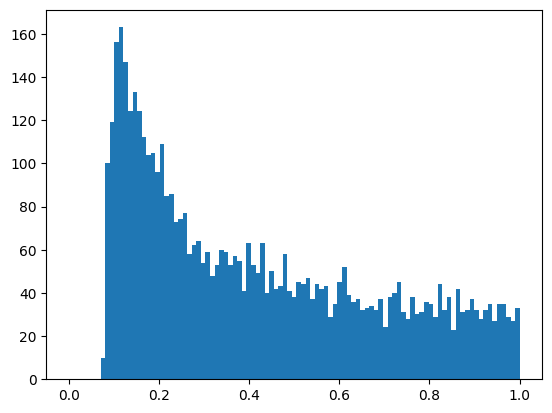

In [6]:
plt.hist(y_test[:,0],bins=np.linspace(0,1,100));

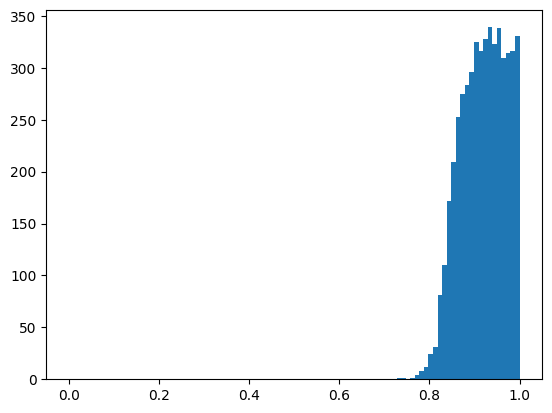

In [7]:
plt.hist(y_test[:,1],bins=np.linspace(0,1,100));

In [8]:
def param_transform(par):
    return minval+tf.math.softplus(par)

def dirichlet_loss(y, p):
    
    alpha = param_transform(p)
    dist = tfp.distributions.Dirichlet(alpha) 
    #tf.print('alpha',alpha)

    A = tf.gather(params=y, indices=[0], axis=1)
    B = tf.gather(params=y, indices=[1], axis=1)
    y_vec = tf.transpose([A, (1-A), B, (1-B)],[2,1,0])
    #tf.print('y',y_vec)
    
    likelihood = dist.prob(0.5*y_vec)  
    #tf.print(likelihood)
    
    likelihood = tf.clip_by_value(likelihood,minval,maxval)

    NLL = -1*tf.math.log(likelihood)
    return tf.keras.backend.sum(NLL,axis=1)  

In [9]:
def CreateModel(shape):
    x = x_in = Input(shape)
    x = Dense(64, name="dense1")(x)
    x = Activation("elu", name="elu1")(x)
    x = BatchNormalization()(x)
    x = Dense(64, name="dense2")(x)
    x = Activation("elu", name="elu2")(x)
    x = BatchNormalization()(x)
    x = Dense(64, name="dense3")(x)
    x = Activation("elu", name="elu3")(x)
    x = BatchNormalization()(x)
    x = Dense(4, name="dense4")(x)
    model = Model(inputs=x_in, outputs=x)
    return model

model=CreateModel(X_train.shape[1:])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss=dirichlet_loss)

model.summary()

2023-02-10 22:23:47.739935: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-10 22:23:47.740061: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-10 22:23:47.740121: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-jennetd): /proc/driver/nvidia/version does not exist
2023-02-10 22:23:47.784574: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 273)]             0         
                                                                 
 dense1 (Dense)              (None, 64)                17536     
                                                                 
 elu1 (Activation)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dense2 (Dense)              (None, 64)                4160      
                                                                 
 elu2 (Activation)           (None, 64)                0         
                                                             

In [10]:
es = EarlyStopping(patience=20,
                  restore_best_weights=True)

history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=200, 
                    batch_size=64,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Epoch 1/200
1250/1250 [==============================] - 9s 5ms/step - loss: -319.2971 - val_loss: -405.3625
Epoch 2/200
1250/1250 [==============================] - 7s 5ms/step - loss: -416.7707 - val_loss: -443.3441
Epoch 3/200
1250/1250 [==============================] - 7s 5ms/step - loss: -442.3411 - val_loss: -462.3492
Epoch 4/200
1250/1250 [==============================] - 6s 5ms/step - loss: -454.9229 - val_loss: -472.6458
Epoch 5/200
1250/1250 [==============================] - 7s 5ms/step - loss: -464.4781 - val_loss: -480.6031
Epoch 6/200
1250/1250 [==============================] - 6s 5ms/step - loss: -471.0970 - val_loss: -485.7727
Epoch 7/200
1250/1250 [==============================] - 6s 5ms/step - loss: -478.0685 - val_loss: -487.9040
Epoch 8/200
1250/1250 [==============================] - 7s 6ms/step - loss: -481.5321 - val_loss: -495.3413
Epoch 9/200
1250/1250 [==============================] - 7s 5ms/step - loss: -486.1572 - val_loss: -494.9423
Epoch 10/200
1250/1

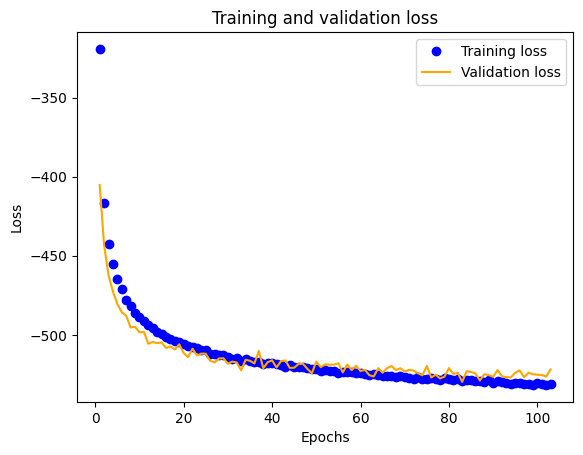

In [11]:
history_dict = history.history
loss_values = history_dict['loss'] 
val_loss_values = history_dict['val_loss'] 
epochs = range(1, len(loss_values) + 1) 
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.yscale('Log')
plt.legend()
plt.show()

157/157 [==============================] - 0s 2ms/step


/tmp/ipykernel_11862/2665933557.py:9: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


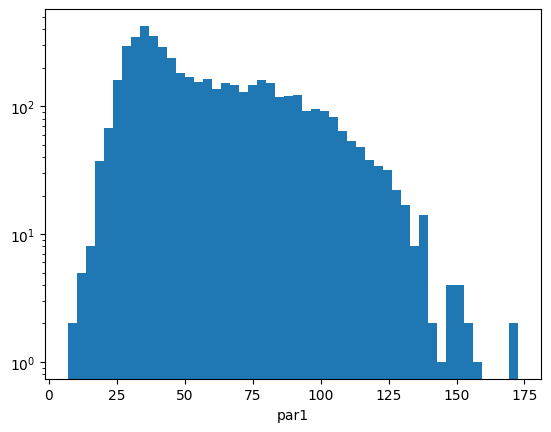

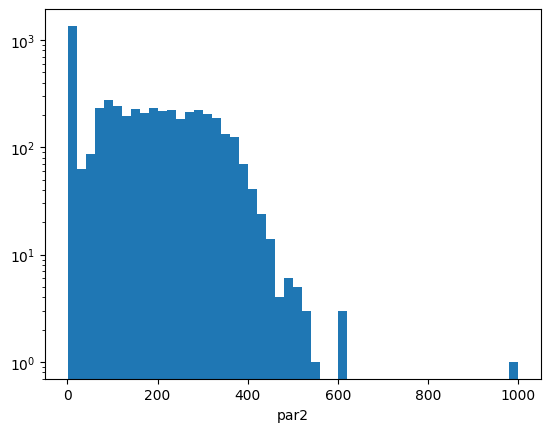

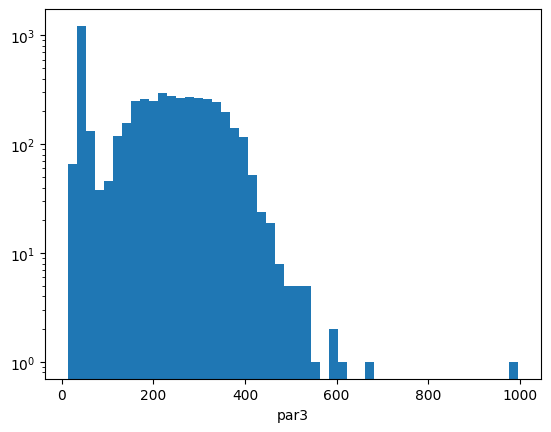

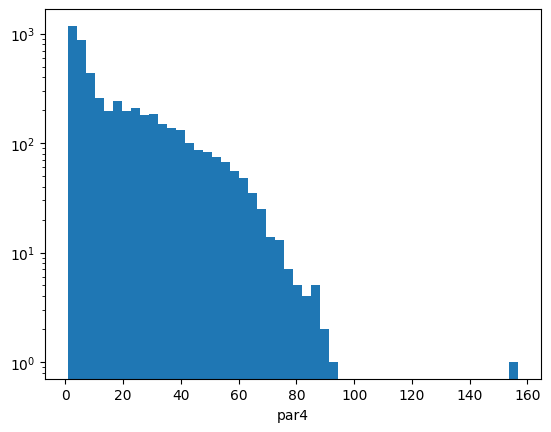

In [13]:
p_test = model.predict(X_test)

pars = ['par1','par2','par3','par4']
df = pd.DataFrame(p_test,columns=pars)
for par in pars:
    df[par] = param_transform(df[par])
    
    plt.hist(df[par],bins=50)
    plt.yscale('Log')
    plt.xlabel(par)
    plt.show()
    
df['Atrue'] = test_df['Alpha']
df['Btrue'] = test_df['Beta']

Text(0, 0.5, 'Param value')

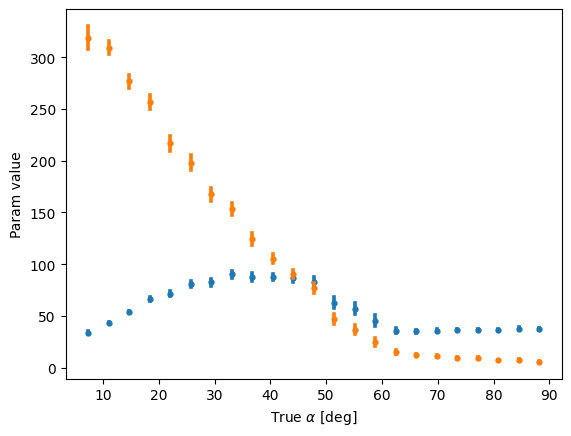

In [14]:
sns.regplot(x=df['Atrue']*180/pi, y=df['par1'], x_bins=np.linspace(0,180,50), fit_reg=None, marker='.')
sns.regplot(x=df['Atrue']*180/pi, y=df['par2'], x_bins=np.linspace(0,180,50), fit_reg=None, marker='.')
plt.xlabel(r'True $\alpha$ [deg]')
plt.ylabel('Param value')
#plt.legend()

Text(0, 0.5, 'Param value')

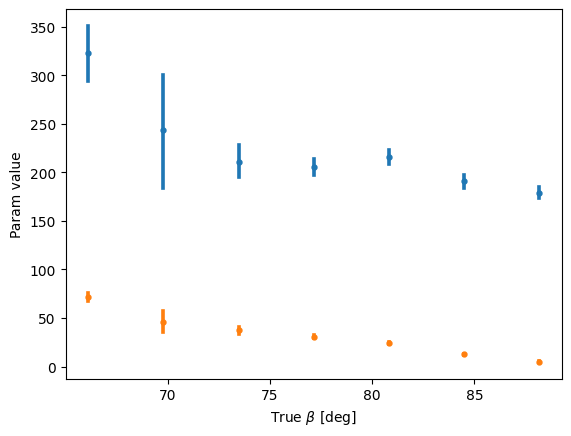

In [15]:
sns.regplot(x=df['Btrue']*180/pi, y=df['par3'], x_bins=np.linspace(0,180,50), fit_reg=None, marker='.')
sns.regplot(x=df['Btrue']*180/pi, y=df['par4'], x_bins=np.linspace(0,180,50), fit_reg=None, marker='.')
plt.xlabel(r'True $\beta$ [deg]')
plt.ylabel('Param value')
#plt.legend()

In [17]:
dist = tfp.distributions.Dirichlet(concentration = df[pars])

In [26]:
df['Amean'] = dist.mean()[:,0]*pi
df['Amode'] = dist.mode()[:,0]*pi

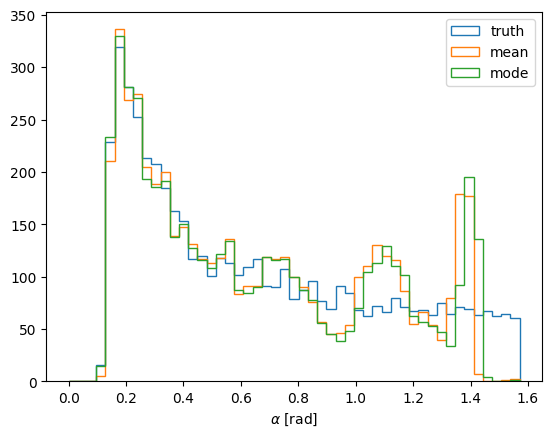

In [27]:
plt.hist(df['Atrue'],bins=np.linspace(0,pi/2,50),histtype='step',label='truth')
plt.hist(df['Amean'],bins=np.linspace(0,pi/2,50),histtype='step',label='mean')
plt.hist(df['Amode'],bins=np.linspace(0,pi/2,50),histtype='step',label='mode')
#plt.yscale('Log')
plt.xlabel(r'$\alpha$ [rad]')
plt.legend()
plt.show()

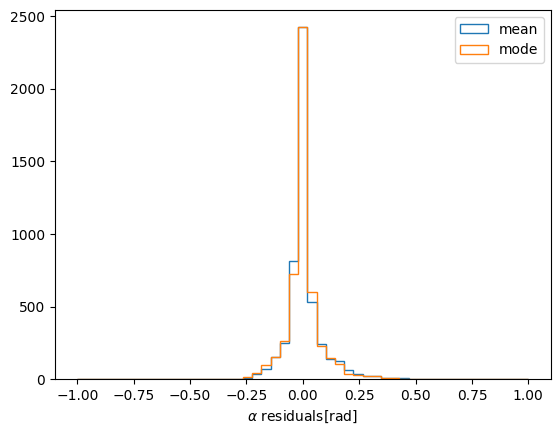

In [36]:
plt.hist(df['Atrue']-df['Amean'],bins=np.linspace(-1,1,50),histtype='step',label='mean')
plt.hist(df['Atrue']-df['Amode'],bins=np.linspace(-1,1,50),histtype='step',label='mode')
#plt.yscale('Log')
plt.xlabel(r'$\alpha$ residuals[rad]')
plt.legend()
plt.show()

In [33]:
df['Bmean'] = dist.mean()[:,1]*pi
df['Bmode'] = dist.mode()[:,1]*pi

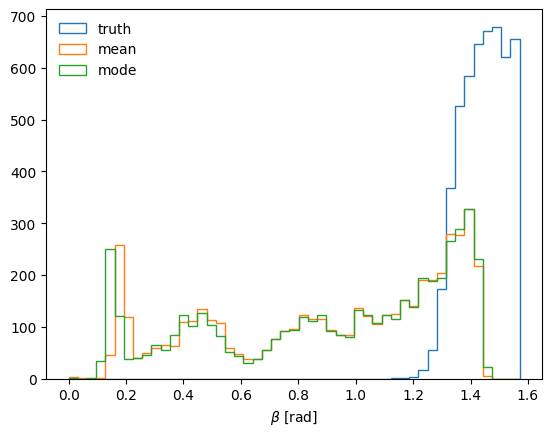

In [34]:
plt.hist(df['Btrue'],bins=np.linspace(0,pi/2,50),histtype='step',label='truth')
plt.hist(df['Bmean'],bins=np.linspace(0,pi/2,50),histtype='step',label='mean')
plt.hist(df['Bmode'],bins=np.linspace(0,pi/2,50),histtype='step',label='mode')
#plt.yscale('Log')
plt.xlabel(r'$\beta$ [rad]')
plt.legend(frameon=False,loc='upper left')
plt.show()

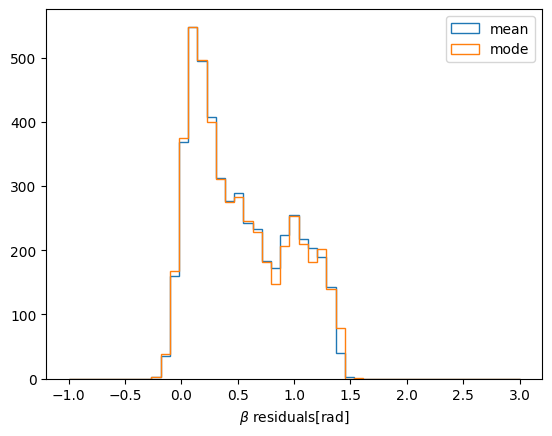

In [38]:
plt.hist(df['Btrue']-df['Bmean'],bins=np.linspace(-1,3,50),histtype='step',label='mean')
plt.hist(df['Btrue']-df['Bmode'],bins=np.linspace(-1,3,50),histtype='step',label='mode')
#plt.yscale('Log')
plt.xlabel(r'$\beta$ residuals[rad]')
plt.legend()
plt.show()

In [39]:
dist.stddev()

<tf.Tensor: shape=(5000, 4), dtype=float32, numpy=
array([[0.00982636, 0.02017443, 0.02029265, 0.0072464 ],
       [0.00897947, 0.01626198, 0.01622307, 0.00938652],
       [0.04808086, 0.02252786, 0.04816604, 0.02358696],
       ...,
       [0.01032073, 0.01964376, 0.01976291, 0.00833005],
       [0.00839121, 0.01759672, 0.0176835 , 0.00651301],
       [0.01533316, 0.01898657, 0.02018674, 0.00781132]], dtype=float32)>